In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
#import gcsfs
import cftime

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/var/folders/k1/5_y16ccj4zv7lcjp767yd1b80000gn/T/ipykernel_12834/598289913.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/hrh/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
chicago_LAT=41.88
chicago_LON=(360-87.6298)%360

In [3]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [4]:
# 2. Search for maximum temperature for July 30
expts = ['ssp370','historical']

cat = col.search(
    experiment_id=expts,
    table_id='day',
    variable_id='tas',
    #grid_label='gn'
)

query = dict(
    experiment_id=expts,
    table_id='day',
    variable_id=['tas'],
    member_id = 'r1i1p1f1',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id","member_id"]
].nunique()

,experiment_id,variable_id,table_id,member_id
source_id,,,,
ACCESS-CM2,2,1,1,1
AWI-CM-1-1-MR,2,1,1,1
BCC-ESM1,2,1,1,1
CESM2-WACCM,2,1,1,1
CMCC-CM2-SR5,2,1,1,1
CMCC-ESM2,2,1,1,1
CanESM5,2,1,1,1
EC-Earth3,2,1,1,1
EC-Earth3-AerChem,2,1,1,1


In [5]:
df = col_subset.df
model_counts = df.groupby('source_id').size()
print(model_counts)

source_id
ACCESS-CM2           2
AWI-CM-1-1-MR        2
BCC-ESM1             2
CESM2-WACCM          2
CMCC-CM2-SR5         2
CMCC-ESM2            2
CanESM5              2
EC-Earth3            2
EC-Earth3-AerChem    2
EC-Earth3-Veg-LR     2
FGOALS-g3            2
GFDL-ESM4            2
IITM-ESM             2
INM-CM4-8            2
INM-CM5-0            2
IPSL-CM5A2-INCA      2
IPSL-CM6A-LR         2
KACE-1-0-G           2
MIROC6               2
MPI-ESM-1-2-HAM      2
MPI-ESM1-2-HR        2
MPI-ESM1-2-LR        2
MRI-ESM2-0           2
NorESM2-LM           2
NorESM2-MM           2
dtype: int64


In [6]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [7]:
%%time
# Trigger computation
dsets_ = dask.compute(dict(dsets))[0]

CPU times: user 3.09 s, sys: 532 ms, total: 3.62 s
Wall time: 13.4 s


In [21]:
def extract_july30_data(ds, chicago_lat=41.88, chicago_lon=(360-87.6298)%360, buffer=1):
    """
    Extract data for July 30 from the dataset 'ds' for specific time and spatial range.

    Parameters:
    - ds (xarray.Dataset): Input dataset
    - chicago_lat (float, optional): Latitude for Chicago. Default is 41.88.
    - chicago_lon (float, optional): Longitude for Chicago. Default is -87.63.
    - buffer (float, optional): Buffer for spatial slice around Chicago. Default is 0.5.

    Returns:
    - xarray.Dataset: Dataset subsetted for July 30 and the specified space and time range.
    """

    
    # Filter by time and space
    subset = ds.sel(
        time=((ds['time.year'] >= 1850) & (ds['time.year'] <= 1879)) | 
              ((ds['time.year'] >= 2071) & (ds['time.year'] <= 2100)),
        lat=slice(chicago_lat - buffer, chicago_lat + buffer),
        lon=slice(chicago_lon - buffer, chicago_lon + buffer)
    )
    
    # Check and deal with different datetime types
    if isinstance(ds['time'].values[0], np.datetime64):
        subset_july30_condition = subset.time.dt.dayofyear == 211
    elif isinstance(ds['time'].values[0], cftime.datetime):
        subset_july30_condition = [date for date in subset['time'].values if (date.month == 7) and (date.day == 30)]
    else:
        raise ValueError("Unknown datetime type in the dataset.")


    # Extract July 30 data
    subset_july30 = subset.sel(time=subset_july30_condition)
    #####subset_july30 = subset

    return subset_july30

In [25]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

#Initialize an Empty Dictionary for Aligned Datasets:
dsets_aligned = {}

#Iterate Over dsets_ Dictionary:
for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year
        ds.coords['day']  = ds.time.dt.dayofyear
        ##print(ds['lat'])
    
    dsets_jul30_chicago = [v[expt].pipe(extract_july30_data)
                             .swap_dims({'time': 'year'})
                             .drop('time')
                      for expt in expts]

    # align everything 
    dsets_aligned[k] = xr.concat(dsets_jul30_chicago, join='outer',
                                 dim=expt_da)

  0%|          | 0/25 [00:00<?, ?it/s]

In [26]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

[########################################] | 100% Completed | 10m 22s


In [27]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

final_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

final_ds

<xarray.Dataset>
Dimensions:        (lat: 26, lon: 8, year: 60, experiment_id: 2, source_id: 25,
                    bnds: 2)
Coordinates:
  * lat            (lat) float64 40.93 40.93 40.95 40.99 ... 42.75 42.86 42.88
  * lon            (lon) float64 271.4 271.9 272.0 272.1 272.2 272.5 272.8 273.1
  * year           (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * experiment_id  (experiment_id) <U10 'ssp370' 'historical'
  * bnds           (bnds) float64 1.0 2.0
  * source_id      (source_id) <U17 'ACCESS-CM2' ... 'NorESM2-MM'
Data variables:
    tas            (source_id, experiment_id, year, lat, lon) float32 nan ......
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP AerChemMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/a9e05595-ad4e-4c63-86e8-cf7ffb09cc95...
    variable_id:            tas
    variant_label:          r1i1p1f1
    version:                v20191108
    netcdf_tracking_ids:    hdl:21.14100/a9e05595-ad4e-4c63-86e8-cf7ffb09cc95...
    version_id:             v20191108

In [12]:
#Select data for specific location to plot
df_loc = final_ds.sel(lat=chicago_LAT,lon=chicago_LON,method='nearest').to_dataframe().reset_index()
df_eoc = final_ds.sel(experiment_id='ssp370').sel(year= slice(2071,2100)).to_dataframe().reset_index()
df_pi  = final_ds.sel(experiment_id='historical').sel(year= slice(1850,1879)).to_dataframe().reset_index()
df_loc.head()

,year,experiment_id,source_id,bnds,lat,lon,tas
0,1850,ssp370,ACCESS-CM2,1.0,41.875,272.25,NaN
1,1850,ssp370,ACCESS-CM2,2.0,41.875,272.25,NaN
2,1850,ssp370,AWI-CM-1-1-MR,1.0,41.875,272.25,NaN
3,1850,ssp370,AWI-CM-1-1-MR,2.0,41.875,272.25,NaN
4,1850,ssp370,BCC-ESM1,1.0,41.875,272.25,NaN


In [13]:
df_pi

,lat,lon,year,source_id,bnds,experiment_id,tas
0,40.934338,271.40625,1850,ACCESS-CM2,1.0,historical,NaN
1,40.934338,271.40625,1850,ACCESS-CM2,2.0,historical,NaN
2,40.934338,271.40625,1850,AWI-CM-1-1-MR,1.0,historical,NaN
3,40.934338,271.40625,1850,AWI-CM-1-1-MR,2.0,historical,NaN
4,40.934338,271.40625,1850,BCC-ESM1,1.0,historical,NaN
...,...,...,...,...,...,...,...
311995,42.879581,273.12500,1879,MRI-ESM2-0,2.0,historical,NaN
311996,42.879581,273.12500,1879,NorESM2-LM,1.0,historical,NaN
311997,42.879581,273.12500,1879,NorESM2-LM,2.0,historical,NaN
311998,42.879581,273.12500,1879,NorESM2-MM,1.0,historical,NaN


KeyError: 'y'

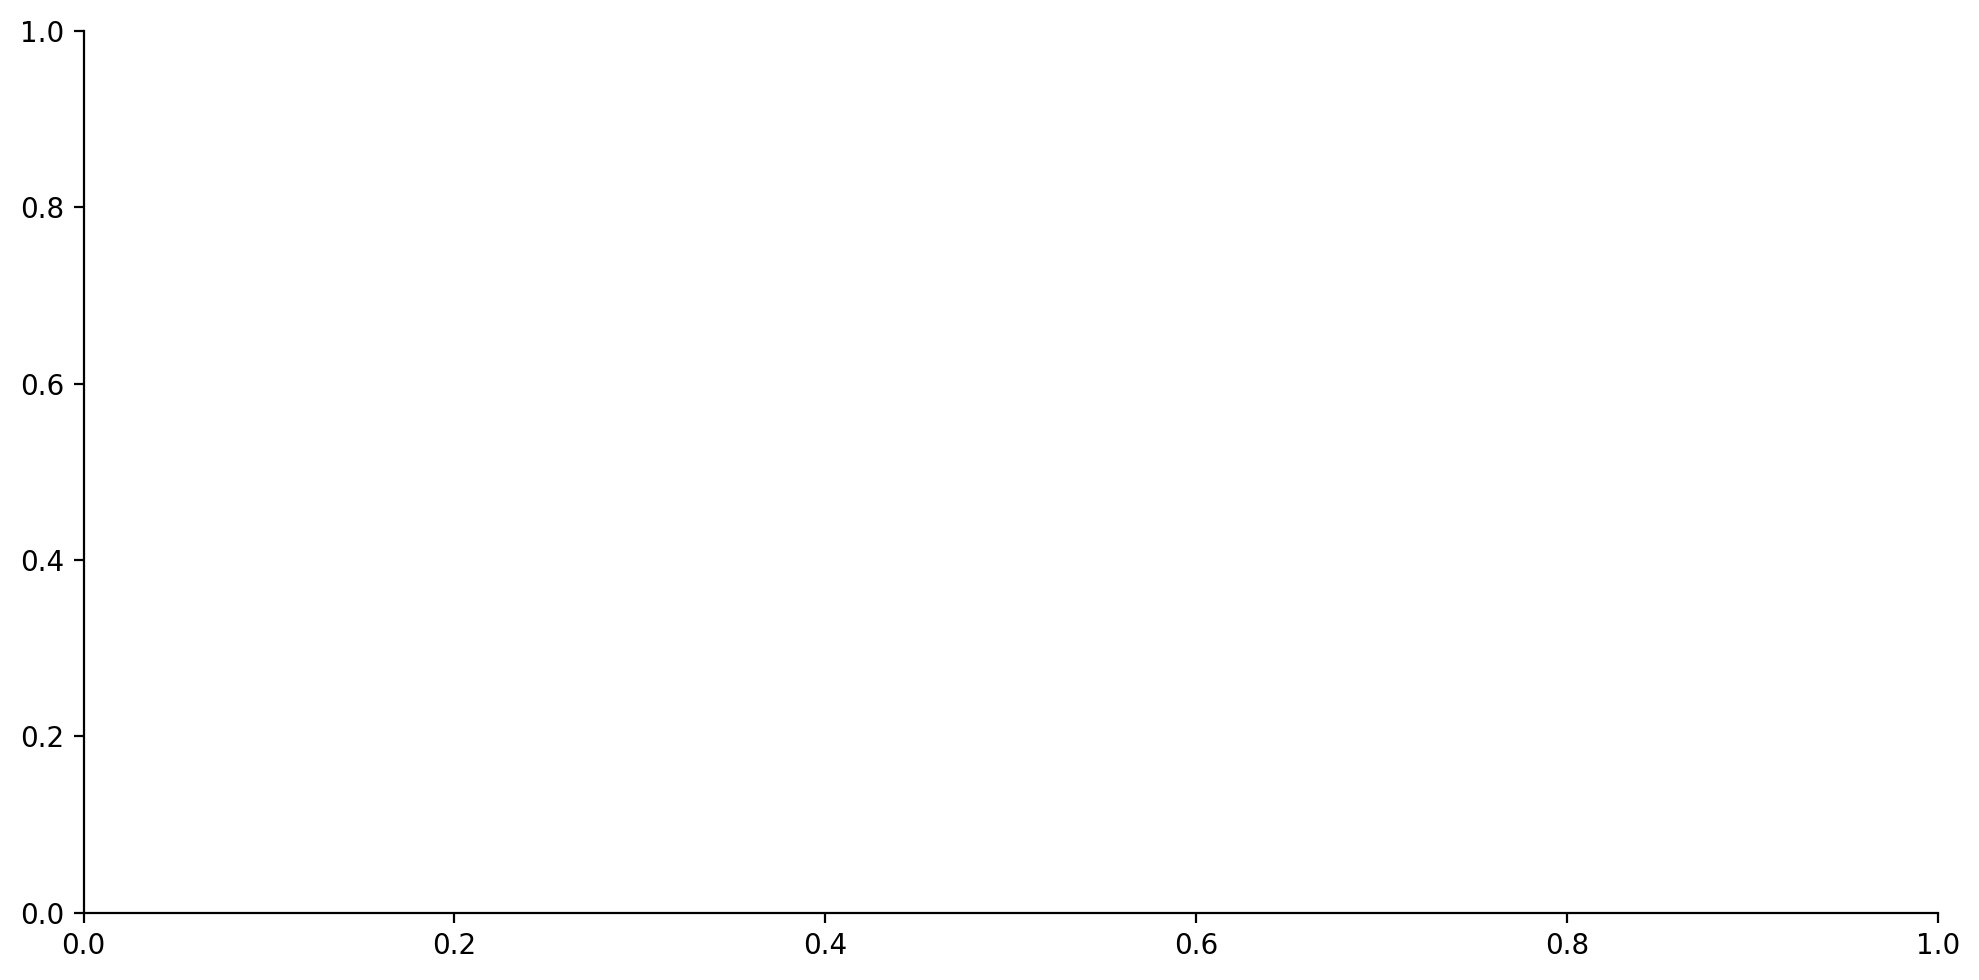

In [14]:
sns.relplot(data=df_loc,x="year", y="tas", hue='experiment_id',
            kind="line", errorbar="sd", aspect=2);